In [ ]:

parent_path='../Data/New_Data_15-06-2020/'
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from utils.marking_similars import *
from utils.preprocess import *

In [19]:
whatsapp_data=pd.read_csv(parent_path+'Data_text_spam_removed_v02.csv')
temp=whatsapp_data[['group_id_anonymized','phone_num_anonymized','message_text','timestamp']]
duplicateDFRow = temp[temp.duplicated()]
whatsapp_data=whatsapp_data.drop(list(duplicateDFRow.index))

In [29]:
thresh_to_consider = 0.8
signature_obj=Signature(10)


def remove_duplicates_within(sample_df):
    sample_df=signature_obj.add_signatures(sample_df)
    id_done=0
    duplicate={}
    row_repeated=[]
    for index,row in tqdm(sample_df.iterrows(),total=len(sample_df)):
        
        id_done+=1
        try:
            temp_dupl=duplicate[index]
            continue
        except KeyError:
            temp_repeated=row['repeated']
            temp=sample_df[id_done:]
            for index1,row1 in temp.iterrows():
                try:
                    temp_dupl=duplicate[index]
                    continue
                except KeyError:
                    signature1=row['signatures']
                    signature2=row1['signatures']
                    count=0
                    for k in range(0, signature_obj.numHashes):
                        count = count + (signature1[k] == signature2[k])
                    # add to tuple similar if greater than thresh    
                    if((count/signature_obj.numHashes)>thresh_to_consider):
                        duplicate[index1]=1
                        temp_repeated+=row1['repeated']
            temp_repeated=list(set(temp_repeated))
            row_repeated.append(temp_repeated)
    sample_df=sample_df.drop(list(duplicate.keys()))
    sample_df['repeated']=row_repeated
    return sample_df

In [30]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data.pkl')
annotated_df=remove_duplicates_within(annotated_df)

  0%|          | 0/5338 [00:00<?, ?it/s]

2552858


100%|██████████| 5338/5338 [14:43<00:00,  6.04it/s] 


In [38]:
import numpy as np

countrepeat_list=[]
count_missing=0
for index,row in annotated_df.iterrows():
    if(len(row['repeated'])>0):
        countrepeat_list.append(len(row['repeated']))
    else:
        countrepeat_list.append(0)
        count_missing+=1
annotated_df['times_repeated']=countrepeat_list

335


In [39]:
annotated_df=annotated_df[annotated_df['times_repeated']>0]

In [52]:
annotated_df.to_pickle(parent_path+'Fearspeech_data_final.pkl')

In [40]:
all_fear_speech_index=[]
all_normal_index=[]

count_fearspeech=0
count_normal=0

for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    if(row['one_fear_speech']==1):
        count_fearspeech+=1
        all_fear_speech_index+=row['repeated']
    elif(row['one_fear_speech']==0):
        count_normal+=1
        all_normal_index+=row['repeated']

data_fear_speech=whatsapp_data[whatsapp_data['orig_index'].isin(all_fear_speech_index)]
data_normal=whatsapp_data[whatsapp_data['orig_index'].isin(all_normal_index)]


100%|██████████| 4782/4782 [00:00<00:00, 13298.67it/s]


In [51]:
print("Fear speech:",len(annotated_df[annotated_df['one_fear_speech']==1]))
print("Normal:",len(annotated_df[annotated_df['one_fear_speech']==0]))

Fear speech: 1142
Normal: 3640


In [49]:
def data_stats(df,whatsapp_data):
    df_groups=df.group_id_anonymized.unique()
   
    average_user_per_group= 0
    for group in df_groups:
        number_of_users=whatsapp_data[whatsapp_data['group_id_anonymized']==group].phone_num_anonymized.nunique()
        average_user_per_group+=number_of_users
    average_user_per_group/= len(df_groups)
    
    average_message_per_group= 0
    for group in df_groups:
        num_of_messages=len(whatsapp_data[whatsapp_data['group_id_anonymized']==group])
        average_message_per_group+=num_of_messages
    average_message_per_group/= len(df_groups)
    
    average_fear_user_per_group= 0
    for group in df_groups:
        number_of_users=df[df['group_id_anonymized']==group].phone_num_anonymized.nunique()
        average_fear_user_per_group+=number_of_users
    average_fear_user_per_group/= len(df_groups)
    
    average_fear_message_per_group= 0
    for group in df_groups:
        num_of_messages=len(df[df['group_id_anonymized']==group])
        average_fear_message_per_group+=num_of_messages
    average_fear_message_per_group/= len(df_groups)
    
    df_users=df.phone_num_anonymized.unique()
    
    avg_number_group_per_users=0
    for user in df_users:
        number_of_users=whatsapp_data[whatsapp_data['phone_num_anonymized']==user].group_id_anonymized.nunique()
        avg_number_group_per_users+=number_of_users
    avg_number_group_per_users/=len(df_users)
    
    
    average_fear_message_per_user= 0
    for user in df_users:
        num_of_messages=len(df[df['phone_num_anonymized']==user])
        average_fear_message_per_user+=num_of_messages
    average_fear_message_per_user/= len(df_users)
    
    average_message_per_user= 0
    for user in df_users:
        num_of_messages=len(whatsapp_data[whatsapp_data['phone_num_anonymized']==user])
        average_message_per_user+=num_of_messages
    average_message_per_user/= len(df_users)

    ###average message length in chars
    sum1=0
    for index,row in tqdm(df.iterrows(),total=df.shape[0]):
        sum1+=len(preprocess_sent(row["message_text"],params={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': True}))
    average_message_length= sum1/len(df)
        
    
    dict1={}
    
    dict1["Total message"]=len(df)
    dict1["Total unique message"]=len(annotated_df[annotated_df['one_fear_speech']==1])
    dict1["Total users having atleast one fear speech (Fear speech users)"]=len(df_users)
    dict1["Total groups having atleast one fear speeach (Fear speech groups)"]=len(df_groups)
    dict1["Total languages"]=len(df.groupby('language'))
    dict1["Average number of users in Fear speech group"]=int(average_user_per_group)
    dict1["Average number of message in Fear speech group"]=int(average_message_per_group)
    dict1["Average number of fear speech users  in Fear speech group"]=int(average_fear_user_per_group)
    dict1["Average number of fear speech in Fear speech group"]=int(average_fear_message_per_group)
    dict1["Average number of groups by Fear speech users"]=int(avg_number_group_per_users)
    dict1["Average number of fear messages by Fear speech users"]=int(average_fear_message_per_user)
    dict1["Average number of messages by Fear speech users"]=int(average_message_per_user)
    dict1["Average message length of fear speech messages"]=int(average_message_length)
    return dict1

In [50]:
data_stats(data_fear_speech,whatsapp_data)

100%|██████████| 7848/7848 [01:45<00:00, 74.17it/s] 


{'Total message': 7848,
 'Total unique message': 1142,
 'Total users having atleast one fear speech (Fear speech users)': 2935,
 'Total groups having atleast one fear speeach (Fear speech groups)': 950,
 'Total languages': 4,
 'Average number of users in Fear speech group': 89,
 'Average number of message in Fear speech group': 1230,
 'Average number of fear speech users  in Fear speech group': 4,
 'Average number of fear speech in Fear speech group': 8,
 'Average number of groups by Fear speech users': 1,
 'Average number of fear messages by Fear speech users': 2,
 'Average number of messages by Fear speech users': 138,
 'Average message length of fear speech messages': 500}

In [53]:
repeat_tuples=[]
fear_speech_count=0
for index,row in annotated_df.iterrows():
    if(row['one_fear_speech']==1):
        repeat_tuples.append([index,len(row['repeated']),'Fear speech'])
        fear_speech_count+=len(row['repeated'])
    else:
        repeat_tuples.append([index,len(row['repeated']),'Normal'])

In [54]:
df_repeat=pd.DataFrame(repeat_tuples,columns=['msg_id','num_repeats','label'])


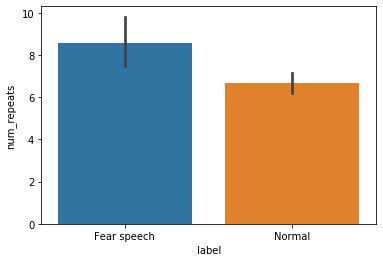

In [58]:
import seaborn as sns
ax = sns.barplot(x="label", y="num_repeats", data=df_repeat)

In [61]:
num_groups_affected=[]
for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    pd.set_option('display.max_colwidth', 300)
    temp=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
    if(row['one_fear_speech']==1):
        num_groups_affected.append([index,len(list(temp['group_id_anonymized'].unique())),'Fear speech'])
    else:
        num_groups_affected.append([index,len(list(temp['group_id_anonymized'].unique())),'Normal'])


100%|██████████| 4782/4782 [00:58<00:00, 81.36it/s] 


In [62]:
df_num_groups=pd.DataFrame(num_groups_affected,columns=['msg_id','groups affected','label'])
ax1 = sns.barplot(x="label", y="groups affected", data=df_num_groups)

In [65]:
num_spreader=[]
for index,row in tqdm(annotated_df.iterrows(),total=len(annotated_df)):
    pd.set_option('display.max_colwidth', 300)
    temp=whatsapp_data[whatsapp_data['orig_index'].isin(row['repeated'])]
    if(row['one_fear_speech']==1):
        num_spreader.append([index,len(list(temp['phone_num_anonymized'].unique())),'Fear speech'])
    else:
        num_spreader.append([index,len(list(temp['phone_num_anonymized'].unique())),'Normal'])


100%|██████████| 4782/4782 [00:59<00:00, 80.89it/s] 


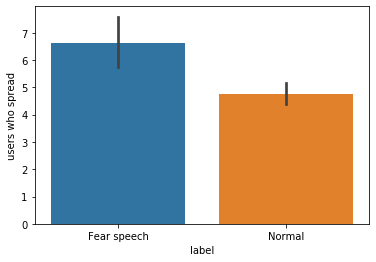

In [66]:
df_num_users=pd.DataFrame(num_spreader,columns=['msg_id','users who spread','label'])
ax1 = sns.barplot(x="label", y="users who spread", data=df_num_users)

In [75]:
import empath

In [76]:
from empath import Empath
lexicon = Empath()

In [78]:
lexicon.cats.keys()

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

In [176]:
dict_map={0:'normal',1:'fear speech'}

def get_empath_categories(df,normalize=True): 
    tuples=[]
    for index,row in df.iterrows():
        dict_lexicon=lexicon.analyze(row['translated'], normalize=normalize)
        try:
            temp=dict_lexicon.values()
        except AttributeError:
            dict_lexicon=lexicon.analyze("sample text", normalize=normalize)
        temp=list(dict_lexicon.values())+[index,dict_map[row['one_fear_speech']]]
        tuples.append(temp)
    df_empath=pd.DataFrame(tuples,columns=list(dict_lexicon.keys())+['org_index','label'])
    
    
    print(len(df),len(df_empath))
    df=df.reset_index(drop=True)
    #df_with_empath=pd.concat([df,df_empath],axis=1)
    return df_empath


In [177]:
annotated_df_empath=get_empath_categories(annotated_df)


4782 4782


In [179]:
annotated_df_empath

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,org_index,label
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.005587,0.000000,0.005587,0.000000,0,fear speech
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,normal
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004587,0.0,0.000000,...,0.000000,0.009174,0.004587,0.0,0.009174,0.000000,0.000000,0.000000,2,fear speech
3,0.000000,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3,normal
4,0.008787,0.0,0.001757,0.001757,0.000000,0.001757,0.000000,0.000000,0.0,0.000000,...,0.000000,0.001757,0.001757,0.0,0.001757,0.000000,0.008787,0.001757,4,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,0.008889,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.004444,...,0.000000,0.000000,0.006667,0.0,0.004444,0.000000,0.004444,0.000000,5333,normal
4778,0.000000,0.0,0.000000,0.000000,0.000000,0.010101,0.000000,0.000000,0.0,0.020202,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5334,fear speech
4779,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.019231,0.000000,0.000000,0.000000,5335,normal
4780,0.002732,0.0,0.000000,0.008197,0.000000,0.005464,0.002732,0.000000,0.0,0.000000,...,0.000000,0.000000,0.008197,0.0,0.000000,0.000000,0.002732,0.005464,5336,fear speech


In [180]:
annotated_df_empath = pd.melt(annotated_df_empath,id_vars="label",var_name="category", value_name="normalized_value")


In [181]:
annotated_df_empath=annotated_df_empath[annotated_df_empath['category']!='org_index']
annotated_df_empath.head()

,label,category,normalized_value
0,fear speech,help,0.000000
1,normal,help,0.000000
2,fear speech,help,0.000000
3,normal,help,0.000000
4,normal,help,0.008787


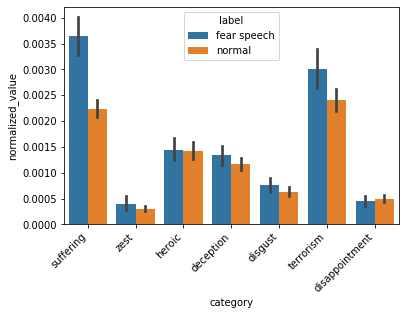

In [190]:
temp=annotated_df_empath[annotated_df_empath['category'].isin(['disappointment','heroic','suffering','zest','disgust','deception','terrorism'])]
font = {
    'weight' : 'normal',
    'size'   : 11}
g = sns.barplot(x="category", y="normalized_value",hue="label",data=temp)
#g=add_values(g,df_admin,15,order_list)
#plt.ylabel('number of groups as admin')
g.set_xticklabels(
        g.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='normal',
        fontsize='medium'

    )
    
plt.show()
#plt.savefig('../Whatsapp_Results/admin_chracterisation_whole_groups.pdf',bbox_inches='tight',dpi=400)

In [80]:
dict_fear_speech=get_empath_categories(annotated_df[annotated_df['one_fear_speech']==1])
dict_not_fear_speech=get_empath_categories(annotated_df[annotated_df['one_fear_speech']==0])



100%|██████████| 3640/3640 [00:00<00:00, 55771.24it/s]

In [81]:
list_all=[]
for key in ['violence','fear','crime','hate','aggression','weapon','negative_emotion']:
    list_all.append((dict_fear_speech[key],key,'fear speech'))
    list_all.append((dict_not_fear_speech[key],key,'not fear speech'))


In [89]:
import matplotlib.pyplot as plt

def plotmultibar(lists,x_axis,y_axis,category,title=None,to_save=False):
    
    df=pd.DataFrame(lists,columns=[x_axis,y_axis,category])
    print(df.head(5))
    ax = sns.barplot(x=y_axis, y=x_axis,hue=category,data=df,orient="v",palette="bright")
    ax.set_xticklabels(
        ax.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='normal',
        fontsize='medium'

    )
    
    
    if(to_save==True):
        fig = ax.get_figure()
        plt.tight_layout()
        plt.savefig('Results/'+title+'.jpg',bbox='tight',dpi=400)
    else:
        plt.show()

   empath value empath category             type
0      0.004252        violence      fear speech
1      0.002527        violence  not fear speech
2      0.001220            fear      fear speech
3      0.000915            fear  not fear speech
4      0.005880           crime      fear speech


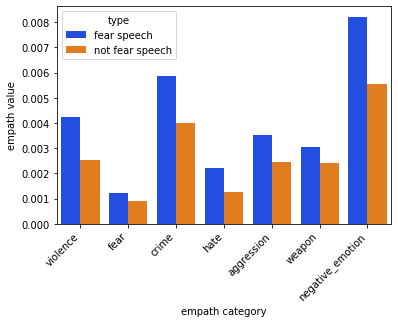

In [90]:
plotmultibar(list_all,'empath value','empath category','type',title='fear speech vs not fear speech',to_save=False)

In [192]:
annotated_df[annotated_df['one_fear_speech']==1][['translated']].to_csv('Fear_speech_translated.csv')